In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
from itertools import product
import matplotlib.pyplot as plt
from models import make_predictions
from preprocess_data import add_epiweek_label, aggregate_data, get_train_data, get_test_data, gen_forecast_dates

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

Nesse notebook será aplicado um modelo LSTM com 2 camadas para realizar a previsão dos casos de dengue.

O modelo usa como input os casos de dengue nas semanas 1-52 dos 3 anos anteriores (y-1) para prever as semanas 1-52 do próximo ano. Além disso o modelo usa como feature a série temporal do enso no último ano e a média dos casos por semana epidemiológica dos últimos anos. Logo, o modelo usa como input 5 features.

Como o output de saída do modelo, segundo o sprint, devem ser as semanas 41-40 eu criei uma função específica para redefinir esse intervalo como 1-52. Logo, essa função transforma um label de uma semana epidemiológica '201041' na semana '201101'.

As semanas 53 foram removidas dos dados. 

Serão utilizados como dados de treinamento os dados de todas as regionais de saúde normalizados. Para realizar a previsão à nível de estado o modelo será retreinado utilizando os dados do estado com poucos épocas e um valor baixo para taxa de aprendizado. (Nesse última passo é como se a técnica de transferência de aprendizado estivesse sendo aplicada)

O dataset abaixo já foi filtrado para MG

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/eduardocorrearaujo/baseline_week/main/data/data_MG.csv')

df.date = pd.to_datetime(df.date)

df.set_index('date', inplace = True)

df.head()

,casos,epiweek,geocode,regional_geocode
date,,,,
2010-01-03,0,201001,3110806,31096
2010-01-03,0,201001,3132404,31003
2010-01-03,0,201001,3168903,31082
2010-01-03,0,201001,3155405,31097
2010-01-03,0,201001,3170602,31093


In [4]:
df.regional_geocode.unique().shape

(89,)

Download dos dados do Enso:

In [5]:
enso = pd.read_csv('data/enso.csv.gz')

enso.date = pd.to_datetime(enso.date)

enso.set_index('date', inplace = True)

enso = enso.loc[enso.index.year >= 2010]

enso = enso.resample('W-SUN').mean()  # Resample to monthly frequency and calculate mean

enso = enso.ffill()

enso = add_epiweek_label(enso)

enso.head()

,enso,epiweek_label,epiweek,year
date,,,,
2010-01-10,1.230226,201014,14,2010
2010-01-17,1.070318,201015,15,2010
2010-01-24,0.957734,201016,16,2010
2010-01-31,1.210819,201017,17,2010
2010-02-07,1.210819,201018,18,2010


As funções abaixo são utilizadas para obter as amostras de treinamento e teste do modelo:

Definição dos dados de treinamento agregando os dados de treinamento de todas as regionais de saúde de MG

Definindo o ano que será predito:

In [6]:
YEAR = 2024

In [7]:
X_train = np.empty((0, 52, 5))

y_train = np.empty((0, 52))

for geo in df.regional_geocode.unique():

    df_w = aggregate_data(df, geo, column = 'regional_geocode')

    data = df_w.merge(enso[['enso']], left_index = True, right_index = True)

    X_train_, y_train_, norm_values_ = get_train_data(data.loc[data.year < YEAR])

    X_train = np.append(X_train, X_train_, axis = 0)

    y_train = np.append(y_train, y_train_ , axis = 0)


In [8]:
print(X_train.shape)
print(y_train.shape)

(890, 52, 5)
(890, 52)


#### Definindo o modelo:

Abaixo há a implementação de 3 arquiteturas diferentes. 

`build_baseline`: Faz o uso de 2 camadas LSTM. 
`build_bi_lstm`: Possui uma camada 1 - Bi-LSTM e outras 2 camadas LSTM
`build_conv_lstm`: Possui uma camada convolutional (CONV) e outras 2 camadas LSTM.

O modelo com melhor performance foi o `build_baseline`.

In [9]:
from models import build_baseline
from keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

In [10]:
model = build_baseline( hidden=32, features=5, predict_n=52, look_back=52, loss='msle', 
                  stateful = False, batch_size = 4,  optimizer = Adam(learning_rate=0.001))

model

/opt/homebrew/Caskroom/miniforge/base/envs/train_lstm/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 52, 5)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (4, 52, 32)            │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 52, 32)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 32)                │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 32)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         1,716 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,900 (58.20 KB)

 Trainable params: 14,900 (58.20 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

## Training the model

No treinamento do modelo são utilizados: 
* Early stopping a partir do erro nos dados de validação;
* 4 camadas para validação cruzada do modelo;
* Treinamentos em batch (batch = 4).

In [11]:

TB_callback = TensorBoard(
        log_dir="./tensorboard",
        histogram_freq=0,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        # embeddings_freq=10
    )

seed = 7
epochs = 100
verbose = 1
monitor = 'val_loss'
min_delta = 0
patience = 20


In [12]:
%%time
# Definição das camadas de validação cruzada
kf = KFold(n_splits=4, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in kf.split(X_train):
    print(f'Training fold {fold_no}...')
    
    # Split data
    X_train_, X_val_ = X_train[train_index], X_train[val_index]
    y_train_, y_val_ = y_train[train_index], y_train[val_index]

    #X_train, X_val, y_train, y_val = train_test_split(
    #X_train, y_train, test_size=0.2, shuffle = False)
    
    hist = model.fit(
                X_train_,
                y_train_,
                batch_size=4,
                epochs=epochs,
                verbose=verbose,
                validation_data=(X_val_, y_val_),
                callbacks=[TB_callback, EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)]
            )

    fold_no = fold_no + 1

Training fold 1...
Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0720 - loss: 0.0088 - mape: 2966969.2500 - mse: 0.0145 - val_accuracy: 0.0807 - val_loss: 0.0071 - val_mape: 4484642.5000 - val_mse: 0.0122
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0781 - loss: 0.0071 - mape: 3770504.5000 - mse: 0.0119 - val_accuracy: 0.0852 - val_loss: 0.0066 - val_mape: 2613133.7500 - val_mse: 0.0117
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0752 - loss: 0.0059 - mape: 2989423.2500 - mse: 0.0099 - val_accuracy: 0.0762 - val_loss: 0.0063 - val_mape: 3033212.2500 - val_mse: 0.0110
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0885 - loss: 0.0054 - mape: 2566601.7500 - mse: 0.0090 - val_accuracy: 0.1121 - val_loss: 0.0062 - val_mape: 2212321.5000 - val_mse: 0.0111
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0925 - loss: 0.0063 - mape: 2909344.7500 - mse: 0.0109 - val_accuracy: 0.1121 - v

Aplicando na regional de BH:

### Retreinando com os dados do estado e aplicando para o ano de teste

In [13]:
df_w = aggregate_data(df)

data = df_w.merge(enso[['enso']], left_index = True, right_index = True)

X_train, y_train, norm_values = get_train_data(data.loc[data.year < YEAR])

X_test, y_test = get_test_data(norm_values,data, year = YEAR)

In [14]:
epochs = 25
model.compile(loss='msle', optimizer = Adam(learning_rate = 0.0001), metrics=["accuracy", "mape", "mse"])

In [15]:
hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=epochs,
            verbose=verbose,
            callbacks=[TB_callback]
        )

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5380 - loss: 0.0027 - mape: 70.2530 - mse: 0.0046
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.2958 - loss: 0.0023 - mape: 63.4060 - mse: 0.0039       
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6137 - loss: 0.0024 - mape: 73.3070 - mse: 0.0039
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4367 - loss: 0.0030 - mape: 63.8310 - mse: 0.0069
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5380 - loss: 0.0022 - mape: 62.8913 - mse: 0.0038 
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6487 - loss: 0.0018 - mape: 71.7935 - mse: 0.0036       
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4188 - loss: 0.0012 - mape: 60.5973 - mse: 0.0022           
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7073 - loss: 8.8910e-04 - mape: 71.7808 - mse: 0.0014   
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step -

Função para realizar as previsões

In [16]:
df_preds = make_predictions(model, X_test, norm_values, dates = gen_forecast_dates(YEAR))

df_preds.head()

,dates,lower,preds,upper
0,2023-10-08,0.0,0.0,0.0
1,2023-10-15,0.0,0.0,0.0
2,2023-10-22,0.0,0.0,0.0
3,2023-10-29,0.0,0.0,0.0
4,2023-11-05,0.0,0.0,0.0


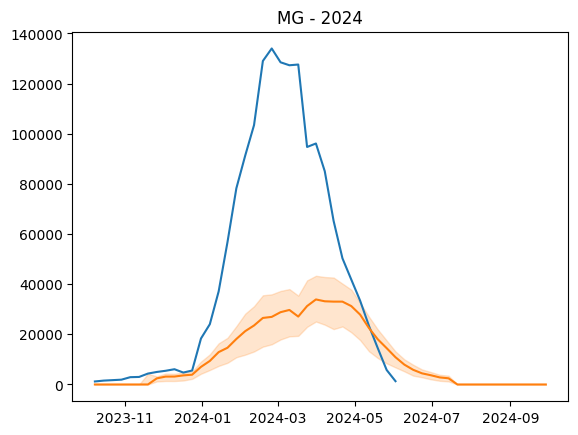

In [17]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == YEAR].casos, label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG - {YEAR}')

plt.show()